In [1]:

import os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image as mg
import cv2
import numpy as np
import tensorflow as tf



In [2]:

WILD_PATH = 'wild'
IMAGE_SIZE = 128

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Getting Images

In [4]:

images = os.listdir('/content/drive/MyDrive/imgs')
train_dir='/content/drive/MyDrive/imgs'

In [10]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
trains = tf.keras.utils.image_dataset_from_directory(train_dir,validation_split=0.3,subset="training",seed=123,image_size=(IMAGE_SIZE, IMAGE_SIZE),)
vals = tf.keras.utils.image_dataset_from_directory(train_dir,validation_split=0.3,subset="validation",seed=123,image_size=(IMAGE_SIZE, IMAGE_SIZE),)
trains = trains.unbatch()
vals = vals.unbatch()
train = []
test = []
for x,y in trains:
    train.append(x.astype('float32')/255.)
for x,y in vals:
    test.append(x.astype('float32')/255.)
train = tf.convert_to_tensor(train)
test = tf.convert_to_tensor(test)

Found 4772 files belonging to 1 classes.
Using 3341 files for training.
Found 4772 files belonging to 1 classes.
Using 1431 files for validation.


In [11]:
print(train.shape)
print(test.shape)

(3341, 128, 128, 3)
(1431, 128, 128, 3)


### Show Random Train Image:

### Convolutional Layers:

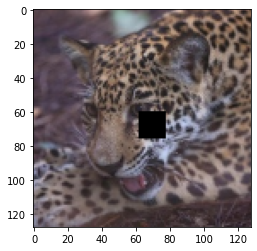

In [12]:
#generating masks
left = 60
right = 76
up = 78
down = 62
x_train = train.numpy()
black_train = x_train.copy()
black_train[:,left:right,down:up,:] = 0
train_labels = x_train[:,left:right,down:up,:]
x_test = test.numpy()
black_test = x_test.copy()
black_test[:,left:right,down:up,:] = 0
test_labels = x_test[:,left:right,down:up,:]
plt.imshow(black_test[0])

In [13]:
from tensorflow.keras.models import Model

encoder_in = tf.keras.Input(shape=(128,128,3),name='img_input')
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Flatten()(layer)
encoder_out = tf.keras.layers.Dense(1024,activation='relu')(layer)     
decoder_in = tf.keras.layers.Dense(1024,activation='relu')(encoder_out)
layer = tf.keras.layers.Reshape((8,8,16))(decoder_in)
layer = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same')(layer)
layer = layer = tf.keras.layers.Conv2DTranspose(64,(3,3),activation='relu',padding='same')(layer)
layer = layer = tf.keras.layers.Conv2DTranspose(128,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same',strides=(2,2))(layer)
decoder_out = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same')(layer)

         
autoencoder = tf.keras.Model(encoder_in,decoder_out,name='an_dec')
# autoencoder.summary()
      

In [14]:

optimizer = tf.keras.optimizers.Adam(lr = 0.001)
autoencoder.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())

In [15]:
history = autoencoder.fit(black_train,train_labels ,
                epochs=50,
                shuffle=True,
                batch_size=10,
                validation_data=(black_test,test_labels))

Epoch 1/50
335/335 [==============================] - 23s 39ms/step - loss: 0.0606 - val_loss: 0.0251
Epoch 2/50
335/335 [==============================] - 13s 38ms/step - loss: 0.0222 - val_loss: 0.0214
Epoch 3/50
335/335 [==============================] - 12s 37ms/step - loss: 0.0188 - val_loss: 0.0213
Epoch 4/50
335/335 [==============================] - 12s 37ms/step - loss: 0.0167 - val_loss: 0.0181
Epoch 5/50
335/335 [==============================] - 12s 37ms/step - loss: 0.0153 - val_loss: 0.0187
Epoch 6/50
335/335 [==============================] - 12s 37ms/step - loss: 0.0140 - val_loss: 0.0193
Epoch 7/50
335/335 [==============================] - 12s 37ms/step - loss: 0.0123 - val_loss: 0.0163
Epoch 8/50
335/335 [==============================] - 12s 37ms/step - loss: 0.0103 - val_loss: 0.0155
Epoch 9/50
335/335 [==============================] - 12s 37ms/step - loss: 0.0091 - val_loss: 0.0169
Epoch 10/50
335/335 [==============================] - 12s 37ms/step - loss: 0.008

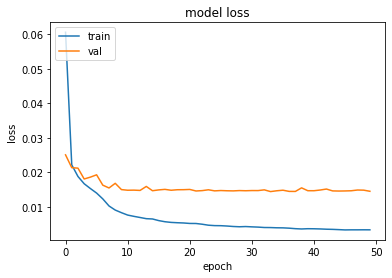

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'input')

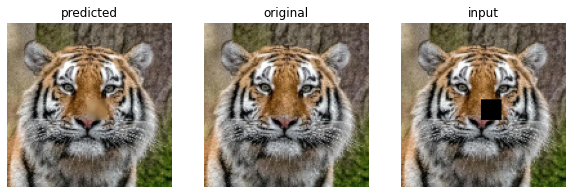

In [24]:
index = 145
ry = autoencoder.predict(black_test[index].reshape(-1,128,128,3))
pic = black_test[index].copy()
pic[left:right,down:up] = ry
rows = 1
colls = 3
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows,colls,1)
plt.imshow(pic)
plt.axis('off')
plt.title("predicted")
fig.add_subplot(rows,colls,2)
plt.imshow(test_xs[index])
plt.axis('off')
plt.title("original")
fig.add_subplot(rows,colls,3)
plt.imshow(black_test[index])
plt.axis('off')
plt.title("input")

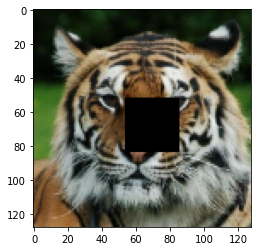

In [25]:
#generating 32x32 holes
left = 52
right = 84
up = 86
down = 54
black_train_bigger = x_train.copy()
black_train_bigger[:,left:right,down:up,:] = 0
train_labels_bigger = x_train[:,left:right,down:up,:]
black_test_bigger = x_test.copy()
black_test_bigger[:,left:right,down:up,:] = 0
test_labels_bigger = x_test[:,left:right,down:up,:]
plt.imshow(black_train_bigger[0])

In [26]:
from tensorflow.keras.models import Model

encoder_in = tf.keras.Input(shape=(128,128,3),name='img_input')
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Flatten()(layer)
encoder_out = tf.keras.layers.Dense(1024,activation='relu')(layer)
       
decoder_in = tf.keras.layers.Dense(1024,activation='relu')(encoder_out)
layer = tf.keras.layers.Reshape((8,8,16))(decoder_in)
layer = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same')(layer)
layer = layer = tf.keras.layers.Conv2DTranspose(64,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.Conv2DTranspose(128,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same',strides=(2,2))(layer)
decoder_out = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same',strides=(2,2))(layer)

          
autoencoder = tf.keras.Model(encoder_in,decoder_out,name='an_dec')
# autoencoder.summary()

In [27]:
optimizer = tf.keras.optimizers.Adam(lr = 0.001)
autoencoder.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())
history = autoencoder.fit(black_train_bigger,train_labels_bigger ,
                epochs=50,
                shuffle=True,
                batch_size=10,
                validation_data=(black_test_bigger,test_labels_bigger))


Epoch 1/50
335/335 [==============================] - 14s 39ms/step - loss: 0.0857 - val_loss: 0.0346
Epoch 2/50
335/335 [==============================] - 12s 37ms/step - loss: 0.0289 - val_loss: 0.0293
Epoch 3/50
335/335 [==============================] - 13s 37ms/step - loss: 0.0256 - val_loss: 0.0260
Epoch 4/50
335/335 [==============================] - 12s 37ms/step - loss: 0.0232 - val_loss: 0.0249
Epoch 5/50
335/335 [==============================] - 13s 38ms/step - loss: 0.0214 - val_loss: 0.0241
Epoch 6/50
335/335 [==============================] - 13s 37ms/step - loss: 0.0197 - val_loss: 0.0240
Epoch 7/50
335/335 [==============================] - 13s 37ms/step - loss: 0.0183 - val_loss: 0.0236
Epoch 8/50
335/335 [==============================] - 12s 37ms/step - loss: 0.0173 - val_loss: 0.0236
Epoch 9/50
335/335 [==============================] - 12s 37ms/step - loss: 0.0165 - val_loss: 0.0238
Epoch 10/50
335/335 [==============================] - 12s 37ms/step - loss: 0.015

Text(0.5, 1.0, 'input')

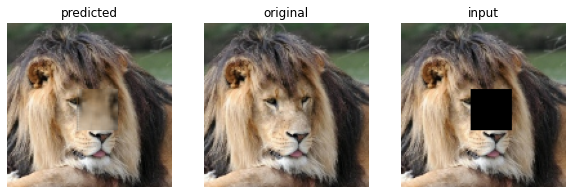

In [37]:
index = 23
ry = autoencoder.predict(black_test_bigger[index].reshape(-1,128,128,3))
pic = black_test[index].copy()
pic[left:right,down:up] = ry
rows = 1
colls = 3
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows,colls,1)
plt.imshow(pic)
plt.axis('off')
plt.title("predicted")
fig.add_subplot(rows,colls,2)
plt.imshow(test[index])
plt.axis('off')
plt.title("original")
fig.add_subplot(rows,colls,3)
plt.imshow(black_test_bigger[index])
plt.axis('off')
plt.title("input")

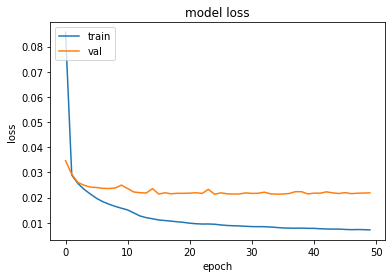

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()